# Ladies' Edinburgh Debating Society as Data
Created August-September 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the *Ladies' Edinburgh Debating Society* Dataset
The Ladies' Edinburgh Debating Society (LEDS) was founded by women in 1865 who were members of the upper-middle and higher classes at a time when women had limited higher education opportunities.  Members went on to play significant roles in education, suffrage, philanthropy, and anti-slavery efforts.  The LEDS Dataset contains digitized text from all volumes of two journals the Society published: "The Attempt" and "The Ladies' Edinburgh Magazine."  The first journal contains 10 volumes published from 1865 through 1874.  The second journal contains six volumes published from 1875 through 1880.  

The Ladies' Edinburgh Debating Society, also known as the Edinburgh Essay Society and the Ladies' Edinburgh Essay Society, was dissolved in 1935.  A year later, in 1936, the National Library of Scotland acquired the volumes that were digitized in this dataset.
* Data format: digitised text
* Data creation process: Optical Character Recognition (OCR)
* Data source: https://data.nls.uk/data/digitised-collections/edinburgh-ladies-debating-society/

### 0. Preparation
Import libraries to use for cleaning, summarising and exploring the data:

In [1]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re
from collections import defaultdict

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer 
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt


[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/lucy/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


The nls-text-ladiesDebating folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitised text, with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitised text and **tokenise** the text (which splits a string into separate words, numbers, and punctuation):

In [2]:
corpus_folder = 'data/nls-text-ladiesDebating/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[:10])

['â', '\x80¢*', 'â', '\x80¢', 'UL', '.', 'u', '^\\,', 'THE', 'ATTEMPT']


*Note: If you'd like to see how to specify a single TXT file to load as data, check out the Jupyter Notebook for the Britain and UK Handbooks!*

It's hard to get a sense of how accurately the text has been digitized from this list of 10 tokens, so let's look at one of these words in context.  To see phrases in which "Edinburgh" is used, we can use the concordance() method:

In [3]:
t = Text(corpus_tokens)
t.concordance('Edinburgh', lines=10)

Displaying 10 of 2079 matches:
UM MELIORIS MVl ." FEINTED FOR THE EDINBURGH ESSAY SOCIETY . EEID & SON , SHORE
atriculated into the University of Edinburgh , where he graduated in Arts , aft
pany has been making a stir in the Edinburgh world ), he was making a long spee
 May proÂ ¬ verbially favours us , Edinburgh holds May one of the dearest of th
on of Ecclesiastical Courts met in Edinburgh this month are no less noteworthy 
wning glory of the month of May in Edinburgh , supplying plenty of gaiety and g
go and find out ." Tlie hair of an Edinburgh cab - owner would stand on end did
onal Gallery . Possibly some of my Edinburgh friends may not have had the oppor
NE CONDUCTED BY THE MEMBERS OF THE EDINBURGH ESSAY SOCIETY . VOLUME III . " AUS
M MELIORIS uEVI ." PRINTED FOR THE EDINBURGH ESSAY SOCIETY . COLSTON & SON , ED


This dataset has not been manually cleaned after OCR digitised text from "The Attempt" and "The Ladies' Edinburgh Magazine" so it's not surprising to see some non-words appear in the concordance.

#### 0.1 Dataset Size
Before we do much analysis, let's get a sense of how much data we're working with:

In [4]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_tokens = 0
    total_sents = 0
    total_files = 0
    
    # fileids are the TXT file names in the nls-text-ladies-Debating folder:
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_tokens += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    
    print("Total...")
    print("  Characters in LEDS Data:", total_chars)
    print("  Tokens in LEDS Data:", total_words)
    print("  Sentences in LEDS Data:", total_sents)
    print("  Files in LEDS Data:", total_files)

corpusStatistics(wordlists)

Total...
  Characters in LEDS Data: 15096132
  Words in LEDS Data: 3145535
  Sentences in LEDS Data: 108011
  Files in LEDS Data: 16


Note that I've print ``Tokens`` rather than words, though the NLTK method used to count those was ``.words()``.  This is because words in NLTK include punctuation marks and digits, in addition to alphabetic words.

#### 0.2 Identifying Subsets of the Data
Next, we'll create two subsets of the data, one for each journal.  To do so we first need to load the inventory (CSV file) that lists which file name corresponds with which journal.    When you open the inventory in Microsoft Excel or a text editor, you can see that there are no column names.  The Python library [Pandas](https://pandas.pydata.org/docs/), which reads CSV files, calls these column names the ``header``.  When we use Pandas to read the inventory, we'll create our own header by specifying that the CSV file as ``None`` and providing a list of column ``names``.

When Pandas (abbreviated ``pd`` when we loaded libraries in the first cell of this notebook) reads a CSV file, it creates a table called a **dataframe** from that data.  Let's see what the LEDS inventory dataframe looks like:

In [5]:
df = pd.read_csv('data/nls-text-ladiesDebating/ladiesDebating-inventory.csv', header=None, names=['fileid', 'title'])
df

,fileid,title
0,109857781.txt,Attempt - Volume 1 and Select writings - U.431
1,103655648.txt,Attempt - Volume 2 - U.431
2,103655649.txt,Attempt - Volume 3 - U.431
3,103655650.txt,Attempt - Volume 4 - U.431
4,103655651.txt,Attempt - Volume 5 - U.431
5,103655652.txt,Attempt - Volume 6 - U.431
6,103655653.txt,Attempt - Volume 7 - U.431
7,103655654.txt,Attempt - Volume 8 - U.431
8,103655655.txt,Attempt - Volume 9 - U.431
9,103655656.txt,Attempt - Volume 10 - U.431


Since we only have 16 files, we'll print the entire dataframe.  With larger dataframes you may wish to use  ``df.head()`` or ``df.tail()`` to print only the first 5 or last 5 rows.

Now we can create a two dictionaries of fileids and their associated journal titles, one for The Attempt and one for The Ladies' Edinburgh Magazine:

In [6]:
attempts = {}
mags = {}
for index, row in df.iterrows():
    fileid = row['fileid']
    title = row['title']
    if 'Attempt' in title:
        attempts[fileid] = title
    else: # if 'Magazine' in title:
        mags[fileid] = title
print("The Attempt files:")
print(attempts)
print("\n Ladies' Edinburgh Magazine files:")  # \n is a newline character, so this prints a blank line between the attempts dictionary and the 'Ladies Edinburgh Magazine files:' string
print(mags)

The Attempt files:
{'109857781.txt': 'Attempt - Volume 1 and Select writings - U.431', '103655648.txt': 'Attempt - Volume 2 - U.431', '103655649.txt': 'Attempt - Volume 3 - U.431', '103655650.txt': 'Attempt - Volume 4 - U.431', '103655651.txt': 'Attempt - Volume 5 - U.431', '103655652.txt': 'Attempt - Volume 6 - U.431', '103655653.txt': 'Attempt - Volume 7 - U.431', '103655654.txt': 'Attempt - Volume 8 - U.431', '103655655.txt': 'Attempt - Volume 9 - U.431', '103655656.txt': 'Attempt - Volume 10 - U.431'}

 Ladies' Edinburgh Magazine files:
{'103655658.txt': "Ladies' Edinburgh Magazine - Volume 1 - U.393", '103655659.txt': "Ladies' Edinburgh Magazine - Volume 2 - U.393", '103655660.txt': "Ladies' Edinburgh Magazine - Volume 3 - U.393", '103655661.txt': "Ladies' Edinburgh Magazine - Volume 4 - U.393", '103655662.txt': "Ladies' Edinburgh Magazine - Volume 5 - U.393", '103655663.txt': "Ladies' Edinburgh Magazine - Volume 6 - U.393"}


For convenient reference of only fileids, we can also create lists from the dictionaries:

In [7]:
attempt_ids = list(attempts.keys())
mag_ids = list(mags.keys())
print(mag_ids)

['103655658.txt', '103655659.txt', '103655660.txt', '103655661.txt', '103655662.txt', '103655663.txt']


NLTK stores the lists of tokens in the corpus_tokens variable we created by the file IDs, so it's useful to be able to match the file IDs with their journal issues!

### 1. Data Cleaning and Standardisation

There are several ways to standardise, or "normalise," text, with each way providing suitable text for different types of analysis.  For example, to study the vocabulary of a text-based dataset, it's useful to remove punctuation and digits, lowercase the remaining alphabetic words, and then reduce those words to their root form (with stemming or lemmatisation - more on this later).  Alternatively, to identify people and places using named entity recognition, it's important to keep capitalisation in words and keep words in the context of their sentences.

#### 1.1 Tokenisation
In section **0. Preparation**, we tokenised the LEDS dataset when we created the ``corpus_tokens`` list.  ``corpus_tokens`` contains a list of all words, punctuation, and numbers that appear in the LEDS dataset separated into individual items and organised in the order they appear in the LEDS text files.  In addition to tokenising words, NLTK also provides methods to tokenise sentences.  This is how we counted the number of sentences in section **0.1 Dataset Size**.

Tokenized words are helpful when analysing the vocabulary of text. Tokenised sentences are helpful when analysing linguistic patterns of a text.  Let's create lists of tokens as *strings* (String is Python's data format for text) from the LEDS dataset:

In [8]:
# Create a list of tokens as strings for the entire corpus
str_tokens = [str(word) for word in corpus_tokens]
print(str_tokens[0:10])

# Create a list of tokens as strings for The Attempt
attempt_str_tokens = []
for fileid in attempt_ids:
    attempt_tokens = wordlists.words(fileid)
    attempt_str_tokens += [str(t) for t in attempt_tokens]
print(attempt_str_tokens[-10:])

# Create a list of tokens as strings for Ladies' Edinburgh Magazine
mag_str_tokens = []
for fileid in mag_ids:
    mag_tokens = wordlists.words(fileid)
    mag_str_tokens += [str(t) for t in mag_tokens]
print(mag_str_tokens[200:210])

['â', '\x80¢*', 'â', '\x80¢', 'UL', '.', 'u', '^\\,', 'THE', 'ATTEMPT']
['January', '.', 'EOISBUROH', ':', 'PRINTED', 'BY', 'COLSTON', 'AND', 'SON', '.']
['the', 'Royal', 'Scottish', 'Academy', ',', 'The', ',', 'by', 'M', '.']


Let's also create a list of tokens that are most likely to be valid English words by removing non-alphabetic tokens from ``str_tokens`` (e.g. punctuation, numbers):

In [9]:
alpha_tokens = [t for t in str_tokens if t.isalpha()]
print(alpha_tokens[1000:1010])

['but', 'her', 'friends', 'had', 'no', 'cause', 'to', 'complain', 'of', 'her']


Knowing that the digitized text in the LEDS dataset wasn't cleaned up after OCR, there may be words whose letters were incorrectly digitized as punctuation or numbers.  To include those words, we'll put all tokens that each have at least one letter in a ``with_letters`` list:

In [10]:
with_letters = [t for t in str_tokens if re.search("[a-zA-z]+", t)]
print(with_letters[2000:2010])

['he', 'is', 'THE', 'ATT', 'LSI', 'PT', 'discharged', 'after', 'the', 'trial']


Next, we'll create lowercased versions of the previous lists of tokens, which can be useful for studying the vocabulary of a dataset, as explained at the beginning of this section:

In [11]:
str_tokens_lower = [(str(word)).lower() for word in corpus_tokens]
alpha_tokens_lower = [t for t in str_tokens_lower if t.isalpha()]
with_letters_lower = [t for t in str_tokens_lower if re.search("[a-zA-z]+", t)]

# Check that the capitalized and lowercased lists of tokens are the same length, as expected
assert(len(str_tokens_lower) == len(str_tokens))       # an error will be thrown if something went wrong   
assert(len(alpha_tokens_lower) == len(alpha_tokens))   # an error will be thrown if something went wrong
assert(len(with_letters_lower) == len(with_letters))   # an error will be thrown if something went wrong

As stated at the start of this section, we can also tokenize sentences.  Tokenizing sentences separates sentences in a text into individual items, important when analyzing sentence structure.  Let's create one list of all sentences in the LEDS corpus, and a dictionary of lists for each file in the corpus:

In [12]:
all_sents = []
sents_by_file = dict.fromkeys(wordlists.fileids())
# Iterate through each file in the LEDS corpus
for fileid in wordlists.fileids():
    file_sents = sent_tokenize(wordlists.raw(fileid))
    all_sents += [str(sent) for sent in file_sents]
    sents_by_file[fileid] = all_sents

print("Sample:", all_sents[200:205])

Sample: ['He reckoned his jokes as a sportsman would count his head of\r\ngame, but the effect was drearily oppressive.', 'Fun must be spontaneous to be delightÂ¬\r\nful, and no one enjoys a joke when he feels that the joker is scoring it as a hit or a\r\nmiss with painful care.', 'Many of the best things ever said are unrecorded, save in the memories of the\r\nhearers ; no one chronicles them, and they go floating about the undercurrents of\r\ntlie world of talk, making little speaking circles whenever they come to the surface,\r\ntill by constant wear the edge is taken off, and they sink for ever among the fossil\r\nB\r\n10 THE ATTEMPT\r\nwitticisms of bygone ages.', 'One such story I have heard of Tliackeray.', 'One Derby\r\nDay he was returning by one of the last trains to London, and saw a little man\r\nrushing wildly about the platform, exclaiming as he looked into each full carriage,\r\n" Good gracious me !']


I wonder if the language changed from The Attempt publication and the Edinburgh Ladies Magazine publication?  Let's create lists of all sentences for each of these publications so the language of the two publications can be compared and contrasted:

In [13]:
attempt_file_sents = dict.fromkeys(attempt_ids)
attempt_sents = []
# Iterate through each file of a publication of The Attempt
for fileid in attempt_ids:
    file_sents = sent_tokenize(wordlists.raw(fileid))
    attempt_sents += [str(sent) for sent in file_sents]
    attempt_file_sents[fileid] = attempt_sents
    
print("Total sentences from The Attempt:", len(attempt_sents))
print("Sample:", attempt_file_sents["103655648.txt"][400:405])
print()
    
mag_file_sents = dict.fromkeys(mag_ids)
mag_sents = []
# Iterate through each file of a publication of Edinburgh Ladies' Magazine
for fileid in mag_ids:
    file_sents = sent_tokenize(wordlists.raw(fileid))  
    mag_sents += [str(sent) for sent in file_sents]
    mag_file_sents[fileid] = mag_sents
    
print("Total sentences from Ladies' Edinburgh Magazine:", len(mag_sents))
print("Sample:", mag_file_sents["103655659.txt"][250:255])

Total sentences from The Attempt: 53053
Sample: ['Is there no one\r\nwhom we could comfort out of our abundance, and whose precious blessings we might\r\nhope to deserve!', 'Gretchen,â\x80\x9d he exclaimed, rising up as the thought seized him,\r\nâ\x80\x9c our old neighbour Dorothea can have but little since her loving son was taken\r\naway: it is the duty of the rich to help the poor, and rich we are compared to the\r\ndesolate widow.', 'What think you, my wife; would it not be seemly that she should\r\npartake of our Christmas bounty!â\x80\x9d The kindly housewife did not reply in words,\r\nbut looking up in her husbandâ\x80\x99s face, gave a pleasant smile and approving nod, and\r\nwas soon again busily engaged with her knitting.', 'With the somewhat impetuous\r\nCarl Holz, to determine anything was at once to do it; so, rising up, he began to\r\nprepare for a walk of some four or five miles through the dense forest in which his\r\nwooden hut was situated.', 'Gretchen would have obj

#### 1.2 Stemming
As we saw in the results of the concordance method, OCR doesn't result in perfectly digitised text.  To get a sense of how many mistakes may have been made in the digitisation process, we can measure how many words in the LEDS dataset are recognizable English words according to a list of words used considered valid in the board game [Scrabble](https://raw.githubusercontent.com/jesstess/Scrabble/master/scrabble/sowpods.txt) (as demonstrated in [this example](https://stackoverflow.com/questions/61362891/python-is-there-an-nltk-corpus-for-english-gb-words)).

As mentioned in section **1.1 Tokenisation**, there are several ways to standardise, or "normalise," text, with each way providing suitable text for different types of analysis.  We're concerned with studying vocabulary, since we want to measure how many of the alphabetic tokens NLTK has identified in the LEDS dataset are valid English words, so we'll work with lowercase, alphabetic tokens from our ``alpha_tokens_lower`` list.

To efficiently measure the number of valid and invalid English words, we can further standardise our data through *stemming*.  Stemming reduces words to their root form by removing suffixes and prefixes.  For example, the word "troubling" has a stem of "troubl."

In the next 3 steps we'll load the Scrabble dataset of valid English words, stem the Scrabble dataset and LEDS dataset, and then see if the stems from the LEDS dataset are present in the Scrabble dataset.

**Step 1:** First we'll load the Scrabble file of words (which helpfully includes British English spellings!) and create a list of those words as a frozen set, which prevents them from being modified accidentally:

In [14]:
file = open('data/scrabble_words.txt', 'r')
scrabble_words = file.read().split('\n')
scrabble_words_lower = [word.lower() for word in scrabble_words]

assert(len(scrabble_words) == len(scrabble_words_lower))  # the number of words shouldn't change when the list is lowercased

print("Total words in Scrabble list:", len(scrabble_words))
print("Sample of English words from the Scrabble list:", scrabble_words_lower[100:120])

Total words in Scrabble list: 267752
Sample of English words from the Scrabble list: ['abattoirs', 'abattu', 'abature', 'abatures', 'abaxial', 'abaxile', 'abaya', 'abayas', 'abb', 'abba', 'abbacies', 'abbacy', 'abbas', 'abbatial', 'abbe', 'abbed', 'abbes', 'abbess', 'abbesses', 'abbey']


**Step 2:** Next we'll stem the tokens in the Scrabble list and the LEDS dataset.  There are different algorithms that one can use to determine the root of a word; we will use the Porter Stemmer.  To make our code as efficient as possible, we'll create *sets* of the Scrabble and LEDS stems; sets are a Python data structure that are similar to lists, except that each item in a set is unique (there are no duplicates).  

This process should give us a smaller number of words to compare and should enable tokens in LEDS to be recognized as English words even if they appeared in a different form in the Scrabble list.

In [15]:
porter = nltk.PorterStemmer()   # NLTK provides other stemming algorithms you can try, too, such as the LancasterStemmer

unique_alpha_lower = list(set(alpha_tokens_lower)) # Remove duplicates from the lowercased, alphabetic tokens in the LEDS dataset
leds_porter_stemmed = [porter.stem(t) for t in unique_alpha_lower]

scrabble_porter_stemmed = [porter.stem(t) for t in scrabble_words_lower]

# Remove duplicates from the Scrabble and LEDS lists of stems
leds_pstemmed_set = list(set(leds_porter_stemmed))
scrabble_pstemmed_set = list(set(scrabble_porter_stemmed))

print(leds_pstemmed_set[:10])
print(scrabble_pstemmed_set[50:60])

['conthm', 'wlier', 'lyttletonâ', 'sox', 'osenc', 'uncharit', 'hovis', 'prefer', 'rewai', 'rabbi']
['fouler', 'globi', 'undisclos', 'engraff', 'revalid', 'unstop', 'palp', 'runcibl', 'sectori', 'unmew']


**Step 3:**  Lastly, we'll compare the stems (root forms) of LEDS tokens to the stems of Scrabble words to gauge how many LEDS tokens are recognizable English words.

In [16]:
recognized_stems = 0
for stem in leds_porter_stemmed:
    if stem in scrabble_porter_stemmed:
        recognized_stems += 1
print("Recognized Stems:", (recognized_stems/len(leds_porter_stemmed))*100,"%")

Recognized Stems: 52.320395201129145 %


Rather than comparing stems in the Scrabble and LEDS dataset, you could also compare lemmas or the entire vocabularies (all lowercased, unique tokens).  Comparing the entire vocabularies will take longer than comparing stems and lemmas, though.

Anyways, it looks as though just under half the words in the LEDS text aren't recognized...how might we figure out what some of those words are meant to be?

#### 1.2 Cleaning Digitization Mistakes
Though a manual review of the digitized LEDS text is the most accurate way to correct mistakes in the OCR process, we can use programming to speed up this process and estimate potential words that could take the place of invalid words.  
***
*For more on the approach used in this subsection, check out [chapter 11, section 3.7 of the NLTK Book](https://www.nltk.org/book/ch11.html#chap-data)*

In [17]:
# Code goes here

 or try: http://www.natcorp.ox.ac.uk/docs/URG/intro.html ???

#### 1.3 Lemmatization
Another way to standardize words by reducing them to a root form is *lemmatization*.  Lemmatization differs from stemming because, though both reduce words to a root form, lemmas are roots that are valid words on their own while stems may be roots that are not valid words on their own.  For example, the word "troubling" has a stem of "troubl" and a lemma of "trouble."

Let's create lemmas for the entire LEDS dataset and each of its publications, The Attempt and Ladies' Edinburgh Magazine:

In [18]:
# Get tokens with at least one letter and lowercase them
attempt_with_letters_lower = [t.lower() for t in attempt_str_tokens if re.search("[a-zA-Z]+", t)]
mag_with_letters_lower = [t.lower() for t in mag_str_tokens if re.search("[a-zA-Z]+", t)]

# Lemmatize the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()

leds_lemmas = [wnl.lemmatize(t) for t in with_letters_lower]
print("Sample of lemmas from the LEDS dataset:\n",leds_lemmas[1050:1060])
print()
attempt_lemmas = [wnl.lemmatize(t) for t in attempt_with_letters_lower]
print("Sample of lemmas from The Attempt:\n",attempt_lemmas[500:510])
print()
mag_lemmas = [wnl.lemmatize(t) for t in mag_with_letters_lower]
print("Sample of lemmas from Ladies' Edinburgh Magazine:\n",mag_lemmas[890:900])

Sample of lemmas from the LEDS dataset:
 ['in', 'others', 'is', 'evidenced', 'in', 'her', 'own', 'work', 'on', 'the']

Sample of lemmas from The Attempt:
 ['of', 'the', 'age', 'of', 'queen', 'elizabeth', 'contrasted', 'with', 'those', 'of']

Sample of lemmas from Ladies' Edinburgh Magazine:
 ['but', 'that', 'power', 'which', 'in', 'the', 'form', 'of', 'religion', 'can']


#### 1.4 Part of Speech Tagging
Another form of standardization in text analysis is tagging sentences, or identifying the parts of speech in sentences.  Identifying parts of speech that compose the structure of sentences is important for analyzing linguistic patterns and comparing the writing styles of different texts.  We'll use NLTK's built-in part of speech tagger to tag sentences for the entire corpus and for each publication (The Attempt and Ladies' Edinburgh Magazine):

In [19]:
# Get a list of words (as strings) for each sentence in the LEDS dataset
leds_sents_lists = wordlists.sents()
# Tag parts of speech in sentences for the entire LEDS corpus
leds_tags = [nltk.pos_tag(sent) for sent in leds_sents_lists]

# # Iterate through each file of a publication of The Attempt to create a 
# # list of strings of words (as strings) for each sentence
# attempt_sents_lists = []
# for fileid in attempt_ids:
#     file_sents = wordlists.sents(fileid)
#     attempt_sents_lists += [str(sent) for sent in file_sents]
# # Tag parts of speech in sentences for The Attempt
# attempt_tags = [nltk.pos_tag(sent) for sent in attempt_sents_lists]

# # Iterate through each file of a publication of Edinburgh Ladies' Magazine to
# # create a list of words (as strings) for each sentence
# mag_sents_lists = []
# for fileid in mag_ids:
#     file_sents = wordlists.sents(fileid)
#     mag_sents_lists += [str(sent) for sent in file_sents]
# # Tag parts of speech in sentences for Ladies' Edinburgh Magazine
# mag_tags = [nltk.pos_tag(sent) for sent in mag_sents_lists]

print(leds_tags[400:405])
# print(attempt_tags[400:405])
# print(mag_tags[400:405])

[[('2', 'CD'), ('.', '.')], [('A', 'DT'), ('Mistake', 'NNP'), ('.', '.')], [('3', 'CD'), ('.', '.')], [('4', 'CD'), ('.', '.'), ('6', 'CD'), ('.', '.')], [('An', 'DT'), ('Appellation', 'NNP'), ('.', '.'), ('Unfriendly', 'RB'), ('.', '.'), ('Casual', 'JJ'), ('hints', 'NNS'), ('.', '.')]]


See mapping signatures to words to get "candidate corrections" for digitization mistakes: https://www.nltk.org/book/ch11.html#chap-data

TO DO: try this on all uncleaned OCR datasets!

In [20]:
# mapping signatures to words and ranking - section 3.7

### 2. Summary Statistics
[Code cells in this section will have one function each, preceded with comments in a markdown cell narrating the summarization process]

#### 2.1 Frequencies and Sizes
Now that we've created some different cuts of the LEDS dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a *frequency distribution*, which is a line chart that shows how many times a token appears in the dataset.  The following 3 steps demonstrate how to visualize frequency distributions.

**Step 1:** Filter the tokens in each LEDS publication to exclude one-letter words, two-letter words, and stop words (such as "and," "a,", and "the"), and lowercase all the tokens:

In [43]:
# Use NLTK's provided stop words for the English language
to_exclude = list(set(stopwords.words('english')))
to_exclude += ['attempt', 'magazine', 'ladies', 'edinburgh']    # add words from the journals' titles

# Filter one-letter words, two-letter words, and  stop words out of the list of The Attempt tokens 
attempt_min_three_letters = []
attempt_min_three_letters += [t.lower() for t in attempt_str_tokens if len(t) > 2]
attempt_filtered_tokens = [t for t in attempt_min_three_letters if not t in to_exclude]
print("Sample The Attempt tokens after filtering:", attempt_filtered_tokens[60:70])

# Filter one-letter words, two-letter words, and  stop words out of the list of Ladies' Edinburgh Magazine tokens 
mag_min_three_letters = []
mag_min_three_letters += [t.lower() for t in mag_str_tokens if len(t) > 2]
mag_filtered_tokens = [t for t in mag_min_three_letters if not t in to_exclude]
print("Sample Ladies' Edinburgh Magazine tokens after filtering:", mag_filtered_tokens[200:210])

Sample The Attempt tokens after filtering: ['katie', 'veronica', '.......', 'royal', 'hospital', 'sick', 'children', 'new', 'yearâ', 'hymn']
Sample Ladies' Edinburgh Magazine tokens after filtering: ['profession', 'women', 'eliza', 'dunbar', '383', 'years', 'naomi', 'smith', '....', '380']


**Step 2:** Calculate the frequency distribution for each LEDS publication using NLTK's ``FreqDist()`` method:

In [45]:
# Calculate the frequency distribution for each filtered list of tokens
attempt_fdist = FreqDist(attempt_filtered_tokens)
print("The Attempt tokens after filtering:", attempt_fdist.N())

mag_fdist = FreqDist(mag_filtered_tokens)
print("Ladies' Edinburgh Magazine tokens after filtering:", mag_fdist.N())

The Attempt tokens after filtering: 675377
Ladies' Edinburgh Magazine tokens after filtering: 622426


**Step 3:** Plot the frequency distributions for each LEDS publication:

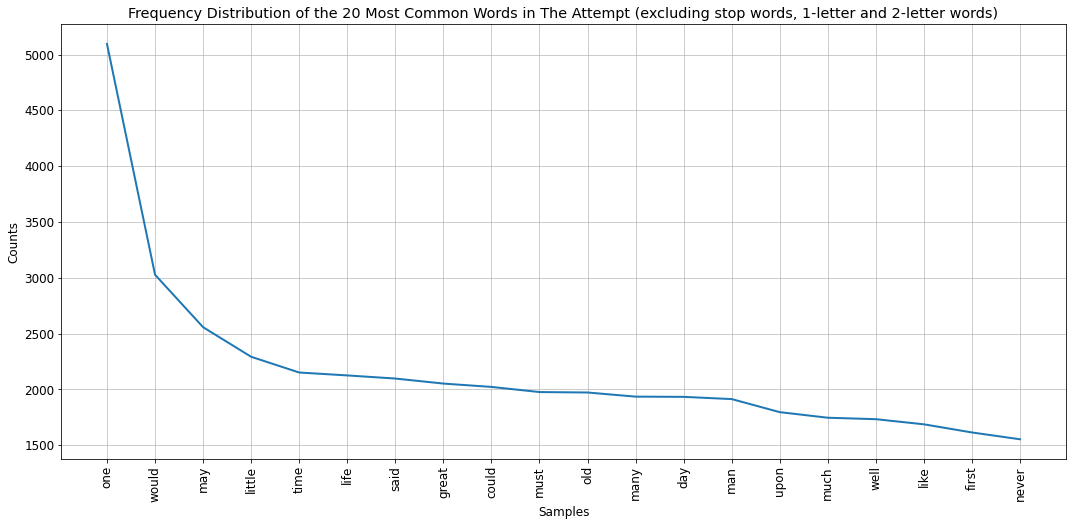

In [46]:
# Visualise the frequency distribution for a select number of tokens 
plt.figure(figsize = (18, 8))                # customise the width and height of the plot
plt.rc('font', size=12)                       # customise the font size of the title, axes names, and axes labels
attempt_fdist.plot(20, title='Frequency Distribution of the 20 Most Common Words in The Attempt (excluding stop words, 1-letter and 2-letter words)')

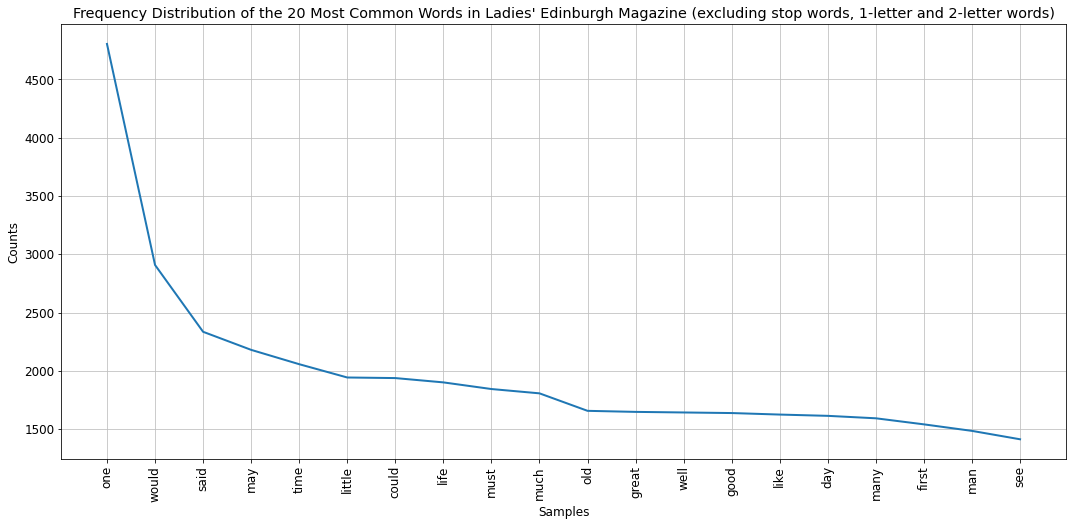

In [47]:
# Visualise the frequency distribution for a select number of tokens
plt.figure(figsize = (18, 8))                # customise the width and height of the plot
plt.rc('font', size=12)                       # customise the font size of the title, axes names, and axes labels
mag_fdist.plot(20, title="Frequency Distribution of the 20 Most Common Words in Ladies' Edinburgh Magazine (excluding stop words, 1-letter and 2-letter words)")

[Discuss charts]

#### 2.2 Uniqueness and Variety

[Narration]

In [25]:
# Remove duplicate lemmas to obtain the vocabulary of the text and each publication
leds_vocab = set(leds_lemmas)
attempt_vocab = set(alpha_tokens)
mag_vocab = set(alpha_tokens_lower)
print("LEDS vocabulary size:", len(leds_vocab), "words")
print("The Attempt vocabulary size:", len(attempt_vocab), "words")
print("Ladies' Edinburgh Magazine vocablary size:", len(mag_vocab), "words")

LEDS vocabulary size: 66202 words
The Attempt vocabulary size: 81408 words
Ladies' Edinburgh Magazine vocablary size: 70850 words


In [26]:
# Lexical Dispersion Plot?
# corpus_text = Text(corpus_tokens)
# targets = []
# plt.figure(figsize=(30,20))
# plt.rc('font', size=20)
# displt(corpus_text, targets, ignore_case=True, title='Lexical Dispersion Plot of ')

### 3. Exploratory Analysis (this section will be included for 2-3 datasets)
[Code cells in this section will have one function each, preceded with comments in a markdown cell posing an exploratory research question]

#### 3.1 Who is named in the dataset?  (Named Entity Recognition)
* https://medium.com/@pavankalyanpk986/named-entity-recognition-with-nltk-ec59ff6a9250
* https://pypi.org/project/gender-guesser/

In [27]:
# code goes here

In [28]:
# visualizations go here

#### 3.2 How many of the people named are found in Wikidata?

In [29]:
# code goes here

In [30]:
# visualizations go here